<a href="https://colab.research.google.com/github/DiGyt/cateye/blob/main/example_pandas_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CatEye: Pandas Workflow Example
_Dirk Gütlin_

In this notebook, I will give show you how you can easily combine your CatEye workflow with [Pandas](https://pandas.pydata.org/) dataframes. This allows us to intuitively apply several CatEye functions while keeping a nice overview over our data. It also allows us to seamlessly leverage all of pandas' functionality designed to facilitate processing and plotting of time series data and tidy data in general. If you are looking for something simpler or don't want to use Pandas in your workflow, check out [minimal use example](https://github.com/DiGyt/cateye/blob/main/example_minimal_use.ipynb).

## Preprocessing

Let's go straight ahead with installing CatEye library. If you have the library already installed in your environment, you can skip this cell.

In [ ]:
# pip install the cateye library from a bash command
!pip install git+https://github.com/DiGyt/cateye.git -q

Now, let's import all the libraries we need.

In [ ]:
# import libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from cateye import (plot_segmentation, plot_trajectory,
                    classify_nslr_hmm, classify_remodnav,
                    discrete_to_continuous, continuous_to_discrete)
from cateye import sample_data_path

Let's load our EyeTracking data. We load our example .csv straight into a pandas DataFrame.

Another good idea is to reset the index to a pandas.Timedelta index right from the start. This will help us with time series operations like resampling. Afterwards lets check our data by calling the df. 

In [ ]:
# load the data and events
df = pd.read_csv(sample_data_path("example_data"))

# set the "Timestamp" field as index
df.index = pd.to_timedelta(df["Timestamp"], unit="S")
df = df.sort_index()

# show it
df

,Timestamp,Theta,Phi
Timestamp,,,
00:01:10.512291,70.512291,0.427579,0.284328
00:01:10.520691,70.520691,0.428165,0.283948
00:01:10.529091,70.529091,0.428584,0.283729
00:01:10.537491,70.537491,0.429152,0.282755
00:01:10.545891,70.545891,0.428907,0.282665
...,...,...,...
00:03:39.965091,219.965091,0.372220,0.228575
00:03:39.973491,219.973491,0.372656,0.227817
00:03:39.981891,219.981891,0.372534,0.227575


Above, you can see that our DataFrame has three columns and one Timestamp index. The "Theta" column corresponds to the radian gaze rotation on the x axis, and the "Phi" column to the radian gaze rotation on the y axis. The "Timestamp" axis could theoretically be dropped as we have set it to our index already. Still, I often find it very helpful to also keep the time in pure seconds format. If you don't have anything corresponding to such a timestamp array, you can create one from the sampling frequency of your recording, using `cateye.sfreq_to_times()`.

Now, we can go on to preprocess that data. Preproccessing our time series data with pandas is really easy. We can for example:
- interpolate specific constant values
- apply specific functions to our data (e.g. convert radian to degrees)
- apply a boxcar median filter
- crop our dataframe between two timepoints
- resample our data to a constant sampling rate

Let's just do this all right now, in only a few lines.

In [ ]:
# interpolate all values that are either 0 or 1
for col in ["Theta", "Phi"]:
    mask = [i in (0, 1) for i in df[col]]
    df[col][mask] = np.nan
df = df.interpolate()

# convert radian data format to degree
df[["Theta", "Phi"]] = df[["Theta", "Phi"]].apply(np.rad2deg)

# Apply a median boxcar to our gaze data
boxcar_size = 3
df[["Theta", "Phi"]] = df[["Theta", "Phi"]].rolling(boxcar_size).median()
df[["Theta", "Phi"]] = df[["Theta", "Phi"]].fillna(method='backfill')

# crop the recording between 80 and 160 seconds
start = 80
stop = 160
df = df.loc[(df["Timestamp"] >= start) & (df["Timestamp"] <= stop)]

# resample to 200 Hz
sfreq = 200
df = df.resample(f"{1/sfreq}S").mean().interpolate()

Now that we have our data in the format that we like to, we can think of adding events to our dataframe. Events might be any type of annotation that you've added to your eyetracking recording, for example external stimuli, triggers, trial indicators, and so on. In our example events, the participant followed a stimulus moving in different patterns. Let's load our events and print out the first few rows for demonstration.

In [ ]:
# load and display the event data
event_df = pd.read_csv(sample_data_path("example_events"))
event_df.head()

,Timestamp,Name
0,70.48039,instruction
1,77.00052,biflicker
2,78.51971,biflicker
3,80.03895,biflicker
4,81.55901,biflicker


As you can see, our events have two columns, one for the Timestamp at which the event starts, and one for the corresponding Name of the event. Note that the timestamps in our events do not correspond to the sampling timestamps in our eyetracking data, neither before nor after preprocessing. Instead, they describe _discrete_ occurences during the course of our recording, which are not neccessarily aligned with the _continuous_ samples of our eyetracking data.

This is a little unfortunate, as we usually want to have all our data in one place, in order to easily handle the data and prevent errors from possible disalignments. For this purpose, cateye provides two functions to transalte between the _discrete_ and the _continuous_ format of our eyetracking data: `discrete_to_continuous` and `continuous_to_discrete`. The former function aligns discrete variables to a continuous time course, returning indices and values that match the continuous time course. The latter function reverts these indices and values back to a discrete time course, creating one timestamp and one value for each index. These functions are kind of "inverse" to each other, such that `discrete_to_continuous(times, continuous_to_discrete(times, indices, values))` will return `indices` and `values` again.

Here we use `discrete_to_continuous` to map our events to our DataFrame, allowing us to append the events to our gaze series DataFrame.

In [ ]:
# transform events and append them to the DataFrame
ev_idx, ev_names = discrete_to_continuous(df["Timestamp"], event_df["Timestamp"], event_df["Name"])
df["Event_Idx"] = ev_idx
df["Event_Name"] = ev_names
df

,Timestamp,Theta,Phi,Event_Idx,Event_Name
Timestamp,,,,,
00:01:20.004291,80.004291,29.596364,19.183573,3.0,biflicker
00:01:20.009291,80.012691,29.596364,19.183573,3.0,biflicker
00:01:20.014291,80.016891,29.596364,19.183573,3.0,biflicker
00:01:20.019291,80.021091,29.596364,19.183573,3.0,biflicker
00:01:20.024291,80.025291,29.596364,19.183573,3.0,biflicker
...,...,...,...,...,...
00:02:39.979291,159.980691,27.610332,17.803648,41.0,instruction
00:02:39.984291,159.989091,27.610332,17.803648,41.0,instruction
00:02:39.989291,159.993291,27.610332,17.803648,41.0,instruction


As we can see, our events are now part of the DataFrame, which now contains all of our data.

## Classification

Now, we can go on and start classifying our eyetracking gaze series. The main purpose of CatEye is to import different gaze classification algorithms and to put them into a uniform structure. Optimally, classifiers should work by calling `classify(gaze_x, gaze_y, times)` and little else. By default, the function returns the segment indices and classes in _continuous_ format, but we could also return the discrete segments by passing `return_discrete=True`.

Here, we will try out the NSLR-HMM and the REMoDNaV algorithms and append them to our DataFrame.

In [ ]:
# add NSLR-HMM classification
segments, classes = classify_nslr_hmm(df["Theta"], df["Phi"], df["Timestamp"], optimize_noise=False)
df["NSLR_Segment"] = segments
df["NSLR_Class"] = classes

Classifiers might require/allow additional arguments, which you can pass directly or through keyword arguments. For REMoDNaV, `px2deg` is a required argument, while `savgol_polyord` can be passed to REMoDNaV's internal preprocessing function.

In [ ]:
# add remodnav class
segments, classes = classify_remodnav(df["Theta"], df["Phi"], df["Timestamp"], px2deg=1.,
                                      preproc_kwargs=dict(savgol_polyord=1), simple_output=True)
df["REMODNAV_Segment"] = segments
df["REMODNAV_Class"] = classes

Now we've already got two distinct types of classifications. Let's check them out by plotting the first rows of our DataFrame.

In [ ]:
# show dataframe
df.head()

,Timestamp,Theta,Phi,Event_Idx,Event_Name,NSLR_Segment,NSLR_Class,REMODNAV_Segment,REMODNAV_Class
Timestamp,,,,,,,,,
00:01:20.004291,80.004291,29.596364,19.183573,3.0,biflicker,1.0,Fixation,1.0,Fixation
00:01:20.009291,80.012691,29.596364,19.183573,3.0,biflicker,1.0,Fixation,1.0,Fixation
00:01:20.014291,80.016891,29.596364,19.183573,3.0,biflicker,1.0,Fixation,1.0,Fixation
00:01:20.019291,80.021091,29.596364,19.183573,3.0,biflicker,1.0,Fixation,1.0,Fixation
00:01:20.024291,80.025291,29.596364,19.183573,3.0,biflicker,1.0,Fixation,1.0,Fixation


Of course, it looks nice, having everything in one place. But it's still hard to get some valuable information from simply looking at the table. For this purpose, cateye introduces some simple but flexible plotting functions, allowing us to nicely visualize our gaze classifications.

## Plotting

The main function for visualization is `plot_segmentation`. This function plots the time course of our gaze data, while coloring each predicted gaze segment with the according class. It also allows us to plot any discrete event as a vertical line onto our gaze data, for example indicating trial starts in an eyetracking experiment.

The ploting functions are intended to be as flexible as possible, with several optional parameters and a seamless integration into the matplotlib plotting framework. As seen below, the plot is treated as a standard matplotlib.pyplot element/axis, and can be changed accordingly.



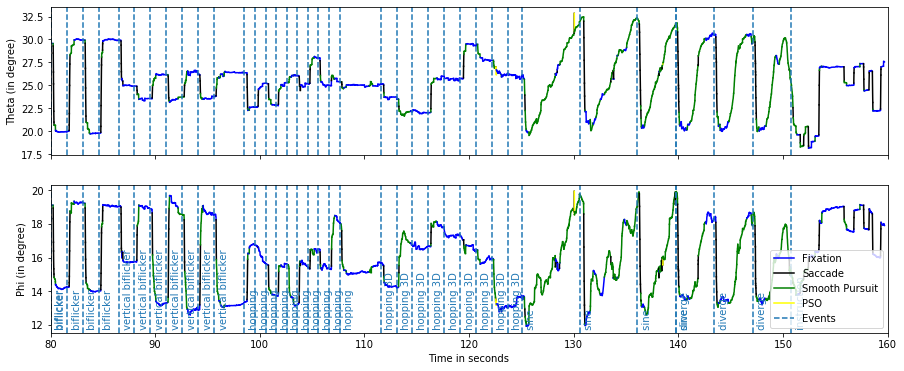

In [ ]:
# convert events and classifications to discrete format (for plotting)
dis_seg_class = continuous_to_discrete(df["Timestamp"],
                                       df["NSLR_Segment"],
                                       df["NSLR_Class"])
dis_events = continuous_to_discrete(df["Timestamp"], df["Event_Idx"],
                                    df["Event_Name"])

# create a matplotlib figure including plots for the x and y gaze array
fig, axes = plt.subplots(2, figsize=(15, 6), sharex=True)   
plot_segmentation(df["Theta"], df["Timestamp"], dis_seg_class, dis_events, ax=axes[0],
                  show_event_text=False, show_legend=False)
plot_segmentation(df["Phi"], df["Timestamp"], dis_seg_class, dis_events, ax=axes[1])

axes[0].set_ylabel("Theta (in degree)")
axes[0].set_xlim([80, 160])
axes[1].set_ylabel("Phi (in degree)")
axes[1].set_xlabel("Time in seconds");

You could also use a custom discrete tuple of (times, values) to either color the segments or annotate the events in the plot. Below, we use events instead of the classification as color marker. For that purpose, we can pass a custom `color_dict`, mapping specific events to specific colors.

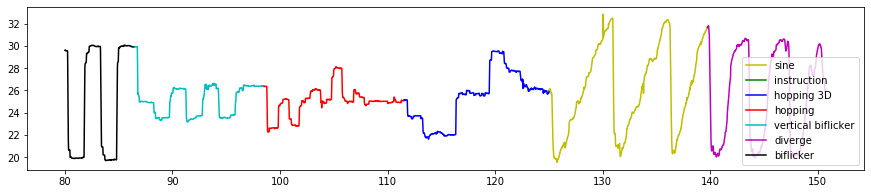

In [ ]:
# create custom color dict
colors = ['y', 'g', 'b', 'r', 'c', 'm', 'k']
c_dict = {k:v for k, v in zip(set(df["Event_Name"]), colors)}

# plot it
plt.figure(figsize=(15, 3))
plot_segmentation(df["Theta"], df["Timestamp"], dis_events, color_dict=c_dict);

The other main plot provided in cateye visualizes the spatial instead of the temporal course of the gaze. Again there are many options to customize the plot and integrate it with matplotlib. 

Let's use this plot to show the classification results of REMoDNaV. In order to keep to plot visually appealing, we should probably not plot the entire recording, but only a short section. Fortunately, filtering is super easy with our combined pandas DataFrame. Let's just select all events during 3D hopping.

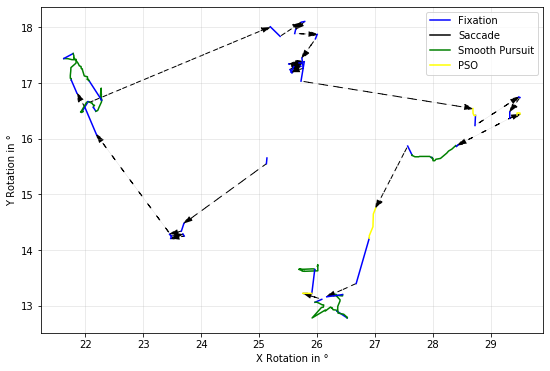

In [ ]:
# create a filter mask for our pandas dataframe
mask = df["Event_Name"] == "hopping 3D"

# discretize the remodnav results
dis_seg_class = continuous_to_discrete(df["Timestamp"], df["REMODNAV_Segment"],
                                       df["REMODNAV_Class"])

# plot the spatial trajectory
plt.figure(figsize=(9, 6))
plot_trajectory(df[mask]["Theta"], df[mask]["Phi"], df[mask]["Timestamp"], dis_seg_class,
                show_legend=True, show_dots=False, show_clean=True, show_arrows=True,
                arrow_kwargs=dict(linestyle=(0, (5, 10))))
plt.grid(alpha=0.3)
plt.xlabel("X Rotation in °")
plt.ylabel("Y Rotation in °");

Using pandas also allows us to use all of pandas internal plotting functions. We can e.g. compare Saccade classification between both our algorithms. Note that the main plot requires only three lines, everything else is embellishment.

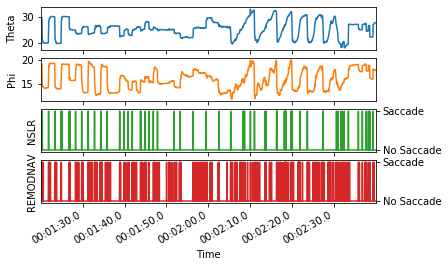

In [ ]:
# add a saccade mask and plot the data
df["NSLR_SP"] = (df["NSLR_Class"] == "Saccade") * 1
df["REMODNAV_SP"] = (df["REMODNAV_Class"] == "Saccade") * 1
axes = df[["Theta", "Phi", "NSLR_SP", "REMODNAV_SP"]].plot(subplots=True, legend=False)

# set labels, axes, etc...
axes[0].set_ylabel("Theta")
axes[1].set_ylabel("Phi")
axes[2].set_ylabel("NSLR")
axes[3].set_ylabel("REMODNAV")
axes[2].yaxis.tick_right()
axes[2].set_yticklabels(["", "No Saccade", "Saccade"])
axes[3].yaxis.tick_right()
axes[3].set_yticklabels(["", "No Saccade", "Saccade"])
plt.xlabel("Time");

Going even further, we can use the [seaborn](https://seaborn.pydata.org/) plotting library, which is highly integrable with pandas. We can for example use it to compare the two classifiers in terms of their prediction frequencies.

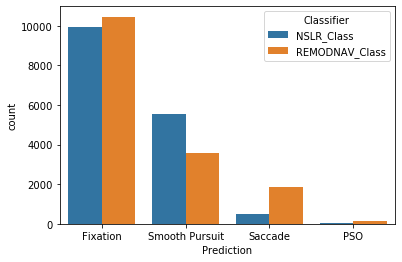

In [ ]:
df_melt = df[["NSLR_Class", "REMODNAV_Class"]].melt(var_name="Classifier",
                                                    value_name="Prediction")
sns.countplot(x="Prediction", hue="Classifier", data=df_melt);

Seaborn uses pandas dataframes to produce more complex plots, e.g. kernel density estimate (KDE) plots. Here we use them to investigate the spatial distribution of our classifiers when prediting post saccadic oscillations.

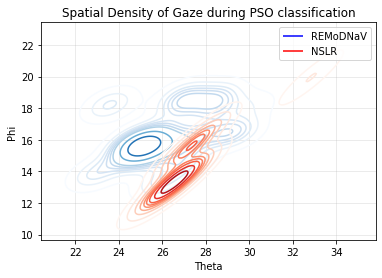

In [ ]:
# kde plot for remodnav
mask = df["REMODNAV_Class"] == "PSO"
sns.kdeplot(df[mask]["Theta"], df[mask]["Phi"], color='b',
            shade=False, cmap="Blues", shade_lowest=False)

# kde plot for nslr
mask = df["NSLR_Class"] == "PSO"
sns.kdeplot(df[mask]["Theta"], df[mask]["Phi"], color='b',
            shade=False, cmap="Reds", shade_lowest=False)

# add legend/title
plt.title("Spatial Density of Gaze during PSO classification")
leg = plt.legend(["REMoDNaV", "NSLR"])
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('red')
plt.grid(alpha=0.3);

Finally, we could use seaborn to visualize how our Theta and Phi gaze time courses relate to each other and to their rates of changes, separated by color according to NSLR-HMM's classification. This helps us get an intuition on how the algorithm works.

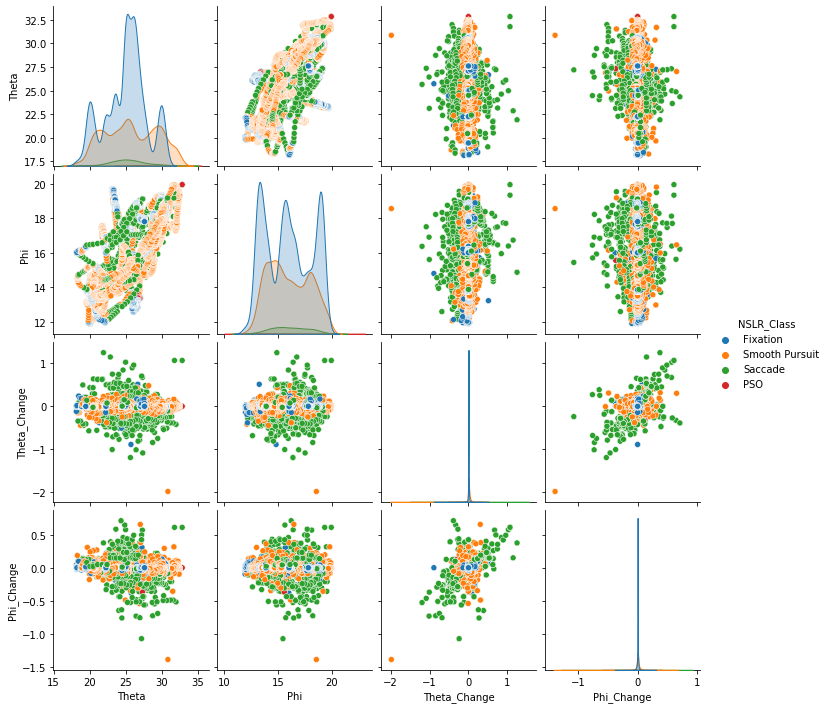

In [ ]:
# calculate the rate of change for Theta and Phi
df["Theta_Change"] = df["Theta"] - df["Theta"].shift()
df["Phi_Change"] = df["Phi"] - df["Phi"].shift()

# create a seaborn pairplot
sns.pairplot(df[["Theta", "Phi", "Theta_Change", "Phi_Change", "NSLR_Class"]],
             hue="NSLR_Class");

That's it. I hope you enjoyed all the nice visualizations and got a good impression of what you can do with CatEye and its integration with pandas dataframes.